In [ ]:
import json

In [ ]:
from matplotlib.ticker import FuncFormatter

In [3]:
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import networkx as nx
import os
import time
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from libs.lizi.my_magi import MyMagiModel
from libs.lizi.my_magi.config import MagiConfig
from libs.lizi.my_magi.utils import UnionFind
from libs.lizi.my_magi.utils import read_image_as_np_array as read_image
from numpy.typing import NDArray
from PIL import Image
from rich.pretty import pprint as pp
from torchmetrics.functional.pairwise import pairwise_cosine_similarity
from transformers.modeling_utils import load_state_dict

In [14]:
import gc

torch.cuda.empty_cache()
gc.collect()

22

In [15]:
from sklearn.cluster import HDBSCAN, AgglomerativeClustering

In [16]:
torch.cuda.is_available()

True

### Uploading images

In [ ]:
# Путь к файлу, куда вы хотите сохранить пустой JSON файл
file_path_json = 'data/json_files/Bleach/Vol74_Ch685.json'

In [178]:
directory_path = "data/masi_mangas/Oshi no Ko/[Ai's fanclub] Vol. 7 Ch. 65"

In [179]:
images_bw = []
images_color = []

In [616]:
@dataclass
class ImageInfo:
    image: np.ndarray
    full_file_name: str
    
    def get_image_array(self):
        return self.image

In [180]:
# Заглушка для чтания файлов из папки с целой главой
for filename in os.listdir(directory_path):
    if filename.endswith("_bw.png"):
        full_path = os.path.join(directory_path, filename)
        try:
            img = np.asarray(Image.open(full_path).convert("RGB"))
            images_bw.append(ImageInfo(image=img, full_file_name=full_path))
        except Exception as e:
            print(f"Ошибка при открытии {full_path}: {e}")
    elif filename.endswith("_color.png"):
        full_path = os.path.join(directory_path, filename)
        try:
            img = np.asarray(Image.open(full_path).convert("RGB"))
            images_color.append(ImageInfo(image=img, full_file_name=full_path))
        except Exception as e:
            print(f"Ошибка при открытии {full_path}: {e}")

### Model initialization

Загружаем pre-train веса из файла в dict

In [625]:
state_dict = load_state_dict(str(Path("models/magi/pytorch_model.bin").resolve()))
state_dict.keys()

dict_keys(['ocr_model.encoder.embeddings.cls_token', 'ocr_model.encoder.embeddings.position_embeddings', 'ocr_model.encoder.embeddings.patch_embeddings.projection.weight', 'ocr_model.encoder.embeddings.patch_embeddings.projection.bias', 'ocr_model.encoder.encoder.layer.0.attention.attention.query.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.key.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.value.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.weight', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.bias', 'ocr_model.encoder.encoder.layer.0.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_before.weight', 'ocr_model.encoder.encoder.layer.0.layernorm_before.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_after.weight', 'ocr_mo

Считываем конфиг из локальной директории и инициализируем нашу модель с ним

In [626]:
config: MagiConfig = MagiConfig.from_json_file(Path("libs/lizi/my_magi/config.json").resolve())  # type: ignore
model = MyMagiModel(config)

Загружаем pre-train веса в модель

In [627]:
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['ocr_model.encoder.embeddings.cls_token', 'ocr_model.encoder.embeddings.position_embeddings', 'ocr_model.encoder.embeddings.patch_embeddings.projection.weight', 'ocr_model.encoder.embeddings.patch_embeddings.projection.bias', 'ocr_model.encoder.encoder.layer.0.attention.attention.query.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.key.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.value.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.weight', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.bias', 'ocr_model.encoder.encoder.layer.0.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_before.weight', 'ocr_model.encoder.encoder.layer.0.layernorm_before.bias', 'ocr_model.encoder.encoder

In [628]:
model.cuda() # type: ignore

MyMagiModel(
  (crop_embedding_model): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_f

### Get embeddings

**image_bboxes** - list со вложенными lists, вложенный список - одна страница, где каждый элемент - np.array
**character_scores** - list с тензорами, тензор - одна страница, каждый элемент - для каждого bbox score
**crop_embeddings_for_batch** - list с тензорами, где каждый тензор - страница, а строка - для каждого bbox
**crop_bboxes** - list c тензорами, где каждый тензор - страница, а строка - для каждого bbox

In [181]:
crop_bboxes_bw = []
crop_embeddings_for_batch_bw = []
image_bboxes_bw = []
character_scores_bw = []
# crop_bboxes_color = []
# crop_embeddings_for_batch_color = []
# image_bboxes_color = []
# character_scores_color = []
images_bw_for_everything_765 = []

In [617]:
@dataclass
class CropBbox:
    id_crop_bbox: int
    image_bbox: np.ndarray # картиночка самого bboxa
    character_score: float # не нужен, но есть
    embeddings_for_batch: torch.Tensor # эмбеддинг для сравнения
    crop_bboxes_for: torch.Tensor # 4 координаты
    file_name: str # имя страницы исходной, иначе хрен сравним с раскраской

In [182]:
list_of_embedddings_765 = []

In [183]:
id_number = 0

In [184]:
for batch in images_bw:
    with torch.no_grad():
        page_image = [batch.image]
        page_name = batch.full_file_name

        (
            batch_crop_bboxes,
            batch_crop_embeddings_for_batch,
            batch_image_bboxes,
            batch_character_scores,
        ) = model.get_crops_and_embeddings(page_image)

    num_rows = len(batch_crop_embeddings_for_batch[0])

    for i in range(num_rows):
        images_bw_for_everything_765.append(
            CropBbox(
                id_crop_bbox=i+id_number,
                image_bbox=batch_image_bboxes[0][i],
                character_score=batch_character_scores[0][i],
                embeddings_for_batch=batch_crop_embeddings_for_batch[0][i],
                crop_bboxes_for=batch_crop_bboxes[0][i],
                file_name=page_name,
            )
        )
        list_of_embedddings_765.append(batch_crop_embeddings_for_batch[0][i])
    
    id_number = id_number + num_rows

---

### Разделим по 100 bboxes

In [ ]:
# Тут подсписки длиной в 100 экземпляров BBox
# sublists_for_clasterization = []
# Тут подсписки длиной в 100 тензоров каждый - тензоры для cosine_simularity
sublists_for_embedddings = []

In [ ]:
for i in range(0, len(list_of_embedddings), 100):
    #sublist_for_bbox = images_bw_for_everything[i:i+100]
    sublist_for_embedddings = list_of_embedddings[i:i+100]
    #sublists_for_clasterization.append(sublist_for_bbox)
    sublists_for_embedddings.append(sublist_for_embedddings)

In [ ]:
# Тут просто в тензоры объединим
list_for_analysis = []

In [ ]:
for one_list in sublists_for_embedddings:
    crop_embedddings_bw = None
    
    # Проходим по каждому элементу в подмножестве
    for i in range(len(one_list)):
        # Извлекаем эмбеддинги из текущего элемента
        current_embeddings = one_list[i].unsqueeze(dim=0)
        
        # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
        if crop_embedddings_bw is None:
            crop_embedddings_bw = current_embeddings
        else:
            # Иначе объединяем текущие эмбеддинги с предыдущими
            crop_embedddings_bw = torch.cat((crop_embedddings_bw, current_embeddings), dim=0)
    
    list_for_analysis.append(crop_embedddings_bw)

### Проба с максимумом по главе

In [ ]:
# Список для поиска совпадений с раскрашенными персами
compare_list = []

In [ ]:
# Перебираем все подмножества в sublists_for_embedddings
for one_pack_for_analysis in list_for_analysis:

    # Матрица с косинусными совпадениями все-на-все
    pcs = pairwise_cosine_similarity(one_pack_for_analysis, one_pack_for_analysis)
    # Меняем единицы в главной диагонали на нули
    pcs = pcs.fill_diagonal_(0.0)
    # Получаем индексы всех максимумов - лучшие совпадения
    new_var = torch.argmax(pcs, dim=1)
    # Объединяем индексы лучших совпадений друг с другом попарно
    char_to = torch.cat(
        (new_var.unsqueeze(1), torch.arange(len(new_var)).cuda().unsqueeze(1)), dim=1
    )
    # Делаем граф из совпадающих вершин
    graphs_chapter_one_max = nx.Graph(char_to.tolist())
    # Объединяем все совпавшие вершины друг с другом  
    indixes_per_chapter = [
        list(c_) for c_ in nx.connected_components(graphs_chapter_one_max)
    ]
    # Создаём список compare_list и добавляем внутри него тензоры
    for c_k in indixes_per_chapter:
        for character_index in range(len(c_k)):
            num = int(c_k[character_index])
            if character_index == 0:
                first_compare_batch = one_pack_for_analysis[num].unsqueeze(dim=0)
            else:
                first_compare_batch = torch.cat(
                    (first_compare_batch, one_pack_for_analysis[num].unsqueeze(dim=0)), dim=0
                )
        compare_list.append(first_compare_batch)


---

### Поиск samples

In [ ]:
directory_path_samples = "data/samples/Bleach"


In [618]:
@dataclass
class SampleImage:
    # sample_image: int
    sample_image: np.ndarray # картиночка 
    # character_score: float # не нужен, но есть
    # embeddings_for_batch: torch.Tensor # эмбеддинг для сравнения
    # crop_bboxes_for: torch.Tensor # 4 координаты
    full_file_name: str # имя страницы исходной для подачи потом в раскраску

images_samples - список, содержащий в себе примеры для окраски в виде numpy arrays

In [ ]:
images_samples = []

In [ ]:
# Заглушка для чтения файлов из папки с примерами раскраски
for filename in os.listdir(directory_path_samples):
    full_path = os.path.join(directory_path_samples, filename)
    try:
        img = np.asarray(Image.open(full_path).convert("RGB"))
        images_samples.append(SampleImage(sample_image=img, full_file_name=full_path))
    except Exception as e:
        print(f"Ошибка при открытии {full_path}: {e}")


In [ ]:
type(images_samples)

In [ ]:
images_color_for_analysis = []

In [ ]:
list_of_compare_embeddings = []

In [619]:
@dataclass
class AnalisysSampleImage:
    id_sample_image: int
    sample_image: np.ndarray # картиночка 
    # character_score: float # не нужен, но есть
    embeddings_for_batch: torch.Tensor # эмбеддинг для сравнения
    # crop_bboxes_for: torch.Tensor # 4 координаты
    full_file_name: str # имя страницы исходной для подачи потом в раскраску

записываем все картинки для раскраски в такую же структуру, что и bboxes

In [ ]:
for batch in images_samples:
    with torch.no_grad():
        page_image = [batch.sample_image]
        page_name = batch.full_file_name

        (
            batch_crop_bboxes,
            batch_crop_embeddings_for_batch,
            batch_image_bboxes,
            batch_character_scores,
        ) = model.get_crops_and_embeddings(page_image)

    num_rows = len(batch_crop_embeddings_for_batch[0])

    for i in range(num_rows):
        images_color_for_analysis.append(
            AnalisysSampleImage(
                id_sample_image=i+id_number,
                sample_image=batch_image_bboxes[0][i],
                embeddings_for_batch=batch_crop_embeddings_for_batch[0][i],
                full_file_name=page_name,
            )
        )
        list_of_compare_embeddings.append(batch_crop_embeddings_for_batch[0][i])
    
    id_number = id_number + num_rows


In [ ]:
images_color_for_analysis[0].embeddings_for_batch.shape

Обрабатываем список с эмбеддингами - делаем из них единый тензор

In [ ]:
crop_embedddings_sample = None

In [ ]:
# Проходим по каждому элементу в подмножестве
for i in range(len(list_of_compare_embeddings)):
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings = list_of_compare_embeddings[i].unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_sample is None:
        crop_embedddings_sample = current_embeddings
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_sample = torch.cat((crop_embedddings_sample, current_embeddings), dim=0)
    

In [ ]:
crop_embedddings_sample.shape

### Сопоставляем эмбеддинги цветных примеров и эмбеддинги bboxes

In [ ]:
compare_list[1].shape

result_dict - тут будет цифра, которая привязана только к sample_dict и подходящие эмбеддинги среди нераскрашенных кропов

In [ ]:
result_dict = {}

sample_dict - тут будет цифра, которая привязана связана с result_dict и эмбеддинг раскраски

In [ ]:
sample_dict = {}

In [ ]:
crop_embedddings_sample.shape

In [ ]:
for one_tensor in compare_list:
    # Составляем матрицу и сравниваем с самплами
    pcs_samples = pairwise_cosine_similarity(one_tensor, crop_embedddings_sample)
    # Ищем сумму по всем значениям
    comp = torch.sum(pcs_samples, dim=0)
    # Ищем индекс максимального совпадения
    max_coincidence = int(torch.argmax(comp))
    if result_dict.get(max_coincidence) is not None:
        inter_res = torch.cat(
                (result_dict[max_coincidence], one_tensor), dim=0)
        result_dict[max_coincidence] = inter_res
    else:
        result_dict[max_coincidence] = one_tensor
        # Запись под аналогичным номером эмбеддинга с примером раскраски
        sample_dict[max_coincidence] = crop_embedddings_sample[max_coincidence]
    

---

### Подача всех необходимых материалов для раскраски

---

### Для подачи картинок для раскраски находим по эмбеддингу пример и bbox

In [ ]:
images_color_for_analysis[0].__dict__.keys()

In [ ]:
images_bw_for_everything[0].__dict__.keys()

In [ ]:
len(result_dict)

Создадим пустой файл json

In [ ]:
directory_path_samples = "data/samples/Bleach"


In [ ]:


# Создание пустого словаря для записи в JSON
empty_data = {}

# Запись пустого словаря в файл JSON
with open(file_path_json, 'w') as f:
    json.dump(empty_data, f, ensure_ascii=False, indent=4)


In [ ]:
existing_data = []

In [ ]:
images_bw_for_everything[0].__dict__.keys()

In [ ]:
images_bw_for_everything[35].image_bbox.shape

In [ ]:
for chosen_key, embedding_color in sample_dict.items():
    corresponding_tensor_in_result_dict = result_dict[chosen_key]

    # тут перебираем среди всех экземпляров класса и находим название картинки с образцом раскраски,у которого совпадает эмбеддинг
    for image in images_color_for_analysis:
        if torch.equal(image.embeddings_for_batch, embedding_color):
            blue_print_img = image.full_file_name

    for i in range(corresponding_tensor_in_result_dict.shape[0]):
        # Извлекаем строку как одномерный тензор размером [768]
        row_as_1d = corresponding_tensor_in_result_dict[i].view(-1)

        for image in images_bw_for_everything:
            if torch.equal(image.embeddings_for_batch, row_as_1d):
                for_coloring = image.file_name
                coordinates = image.crop_bboxes_for
                index_for_name = image.id_crop_bbox
                # ищем аналогичный цветной файл
                new_file_path = for_coloring.replace("_bw.png", "_color.png")
                # вырезаем нужную цветную картинку
                # fid_array = np.array(Image.open(new_file_path))
                fid_array = Image.open(new_file_path)
                # Вырезаем область из изображения
                x1 = int(coordinates[1])
                y1 = int(coordinates[0])
                x2 = int(coordinates[3])
                y2 = int(coordinates[2])
                # width = int(coordinates[3]) - int(coordinates[1])
                # height = int(coordinates[2]) - int(coordinates[0])
                # cropped_color_image = fid_array[
                #    int(coordinates[1]) : int(coordinates[3]),
                #    int(coordinates[0]) : int(coordinates[2]),
                # ]
                cropped_color_image = fid_array.crop((y1, x1, y2, x2))
                filename_color = f"{index_for_name}_output_image_color.png"

                # Image.fromarray(cropped_color_image).save(
                #     f"data/for_diffusion_model/Oshi no Ko/Vol3 Ch28/{filename_color}"
                # )
                cropped_color_image.save(
                     f"data/for_diffusion_model/Bleach/Vol74_Ch685/{filename_color}"
                )
                # Image.fromarray(np.uint8(cropped_color_image)).save(
                #     f"data/for_diffusion_model/Oshi no Ko/Vol3 Ch28/{filename_color}"
                # )

                cropped_black_image = image.image_bbox
                filename_black = f"{index_for_name}_output_black_color.png"

                Image.fromarray(np.uint8(cropped_black_image)).save(
                    f"data/for_diffusion_model/Bleach/Vol74_Ch685/{filename_black}"
                )

                data_to_save = {
                    "File sample name": str(blue_print_img),
                    "Crop bbox": str(filename_black),
                    "For compering": str(filename_color),
                }
                existing_data.append(data_to_save)
                torch.cuda.empty_cache()
        # тут раскраска
        # и сравнение тут же

Запись информации в файл json

In [ ]:
with open(file_path_json, 'w', encoding='utf-8') as f:
    json.dump(existing_data, f, ensure_ascii=False, indent=4)

---

### Метрики

In [ ]:
spisok_of_name = []

In [ ]:
with open('data/json_files/Oshi no Ko/Vol3_Ch28.json', 'r') as file:
    data = json.load(file)

In [ ]:
for i in range(144):
    crop_bbox = str(data[i]['Crop bbox'])
    name = "data/for_diffusion_model/Oshi no Ko/Vol3 Ch28/" + crop_bbox
    spisok_of_name.append(name)

In [ ]:
pp(spisok_of_name)

---

In [ ]:
from PIL import Image
import numpy as np

# Путь к вашему изображению
image_path = 'путь_к_вашему_изображению.png'

# Открытие изображения с помощью PIL
image = Image.open(image_path)

# Преобразование изображения в NumPy массив
numpy_array = np.array(image)

# Теперь вы можете работать с numpy_array как с обычным массивом NumPy
print(numpy_array.shape)  # Выводит размерность массива
print(numpy_array.dtype)  # Выводит тип данных элементов массива

---

In [ ]:
images_bw_for_everything[0].embeddings_for_batch == list_of_embedddings[0]

In [ ]:
pp(list_of_embedddings[0])

In [304]:
len(list_of_embedddings_3_28)

146

In [ ]:
list_of_embedddings_765

In [ ]:
images_bw_for_everything_765

In [ ]:
list_of_embedddings_3_28

In [557]:
Image.fromarray(images_bw_for_everything_765[97].image_bbox)

IndexError: list index out of range

In [19]:
Ai = []
Ruby = []
Akane = []
Cana = []
Memte = []
Aquamarine = []

In [550]:
Ai.append(list_of_embedddings_765[92])

In [424]:
Ruby.append(list_of_embedddings_765[9])

In [387]:
list_of_embedddings_765Akane.append([128])

In [527]:
Cana.append(list_of_embedddings_765[76])

In [392]:
Memte.append(list_of_embedddings_765[131])

In [555]:
Aquamarine.append(list_of_embedddings_765[95])

In [558]:
len(Ruby)

23

In [563]:
len(Aquamarine)

47

In [564]:
New_Ai = Ai[:17]
New_Ruby = Ruby[:17]
New_Akane = Akane[:17]
New_Cana = Cana[:17]
New_Memte = Memte[:17]
New_Aquamarine = Aquamarine[:17]


---

In [565]:
My_new_list = New_Ai + New_Ruby + New_Akane + New_Cana + New_Memte + New_Aquamarine

In [761]:
len(My_new_list)

102

In [567]:
slovar = {"Ai": Ai, "Ruby": Ruby, "Akane": Akane, "Cana": Cana, "Memte": Memte, "Aquamarine": Aquamarine}

---

In [ ]:
/home/userr/MANGA/detection/data/metrics

In [ ]:
empty_data = {}

# Запись пустого словаря в файл JSON
with open(file_path_json, 'w') as f:
    json.dump(empty_data, f, ensure_ascii=False, indent=4)

In [771]:
tensor_cpu = crop_embedddings_all.cpu()

# Преобразование тензора в массив NumPy
nat = tensor_cpu.numpy()

In [773]:
nat.shape

(102, 768)

In [772]:
# Конкретный путь к файлу
file_path = 'data/metrics/formetric.json'

# Открытие файла для записи по указанному пути
with open(file_path, 'w') as file:
    # Запись списка в файл в формате JSON
    json.dump(nat.tolist(), file)


In [5]:
# Конкретный путь к файлу
file_path = 'data/metrics/formetric.json'

### Готовый HDBSCAN

In [605]:
from sklearn.cluster import HDBSCAN, AgglomerativeClustering

hdb = HDBSCAN(min_cluster_size=12, min_samples=3)

In [588]:
crop_embedddings_all = None

In [589]:
# Проходим по каждому элементу в подмножестве
for i in range(len(numpy_arrays_for)):

    torch_tensor_met = torch.from_numpy(numpy_arrays_for[i])
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings_agl = torch_tensor_met.unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_all is None:
        crop_embedddings_all = current_embeddings_agl
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_all = torch.cat((crop_embedddings_all, current_embeddings_agl), dim=0)

In [590]:
type(crop_embedddings_all)

torch.Tensor

In [591]:
hdb.fit(crop_embedddings_all.cpu().numpy())

HDBSCAN(min_cluster_size=12, min_samples=4)

In [592]:
np.array(list(zip(range(len(numpy_arrays_for)), hdb.labels_, hdb.probabilities_, strict=False)))

array([[  0.        ,   0.        ,   1.        ],
       [  1.        ,  -1.        ,   0.        ],
       [  2.        ,   0.        ,   1.        ],
       [  3.        ,   0.        ,   0.93349901],
       [  4.        ,   0.        ,   1.        ],
       [  5.        ,   0.        ,   1.        ],
       [  6.        ,   0.        ,   1.        ],
       [  7.        ,   0.        ,   1.        ],
       [  8.        ,  -1.        ,   0.        ],
       [  9.        ,   0.        ,   1.        ],
       [ 10.        ,   0.        ,   1.        ],
       [ 11.        ,  -1.        ,   0.        ],
       [ 12.        ,   0.        ,   0.94485988],
       [ 13.        ,   0.        ,   1.        ],
       [ 14.        ,   0.        ,   1.        ],
       [ 15.        ,   0.        ,   1.        ],
       [ 16.        ,   0.        ,   1.        ],
       [ 17.        ,   2.        ,   1.        ],
       [ 18.        ,  -1.        ,   0.        ],
       [ 19.        ,   2.     

In [593]:
set(hdb.labels_)

{np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

In [594]:
data_hbd = list(hdb.labels_)

In [672]:
first_line_data = data_hbd[:17]
second_line_data = data_hbd[17:34]
third_line_data = data_hbd[34:51]
fourth_line_data = data_hbd[51:68]
fifth_line_data = data_hbd[68:85]
sixth_line_data = data_hbd[85:102]

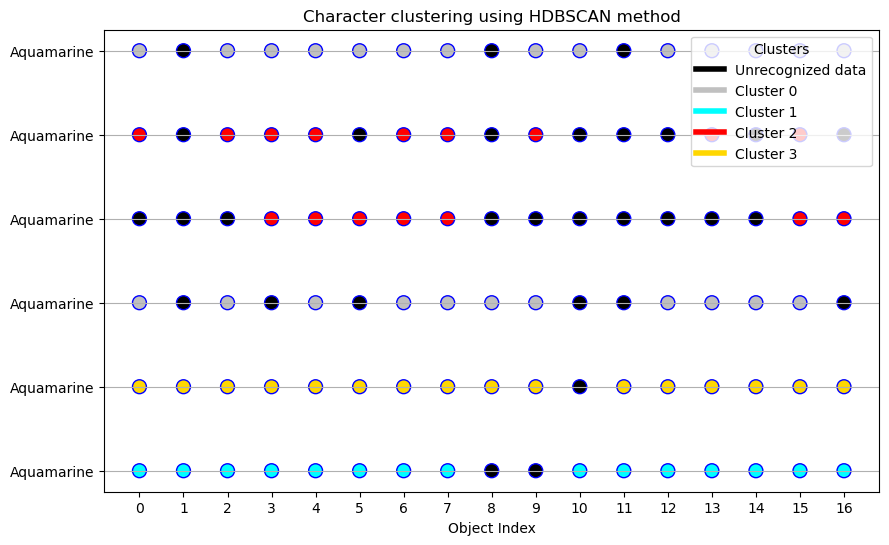

In [673]:
# Ваш код для определения данных остается тем же
x_positions = range(len(first_line_data))


# Функция для форматирования значений оси Y
def format_y(value, tick_number):
    labels = ["Aquamarine", "Memte", "Cana", "Akane", "Ruby", "Ai"]  # Перестроенный порядок
    return labels[int(value * 0.2)]  # Умножаем на 5, чтобы получить индекс из диапазона от 0 до 5


formatter = FuncFormatter(format_y)

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Добавляем первую строку точек на графике
plt.scatter(
    x_positions,
    [1.0] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in first_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="First Line",
)

# Добавляем вторую строку точек на графике
plt.scatter(
    x_positions,
    [0.8] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in second_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Second Line",
)

# Добавляем третью строку точек на графике
plt.scatter(
    x_positions,
    [0.6] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in third_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Third Line",
)

# Добавляем четвертую строку точек на графике
plt.scatter(
    x_positions,
    [0.4] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in fourth_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fourth Line",
)

# Добавляем пятую строку точек на графике
plt.scatter(
    x_positions,
    [0.2] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in fifth_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fifth Line",
)

# Добавляем шестую строку точек на графике
plt.scatter(
    x_positions,
    [0] * len(x_positions),
    c=[
        "black"
        if label == -1
        else ("silver" if label == 0 else "cyan" if label == 1 else "red" if label == 2 else "gold")
        for label in sixth_line_data
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Sixth Line",
)


# Создаем список для легенды с указанием цветов
legend_elements = [
    plt.Line2D([0], [0], color="black", lw=4, label="Unrecognized data"),
    plt.Line2D([0], [0], color="silver", lw=4, label="Cluster 0"),
    plt.Line2D([0], [0], color="cyan", lw=4, label="Cluster 1"),
    plt.Line2D([0], [0], color="red", lw=4, label="Cluster 2"),
    plt.Line2D([0], [0], color="gold", lw=4, label="Cluster 3"),  # Повторяем зеленый для удобства
]

# Добавляем легенду для меток кластеров
plt.legend(handles=legend_elements, title="Clusters")



formatter = FuncFormatter(format_y)
ax.yaxis.set_major_formatter(formatter)
plt.title("Character clustering using HDBSCAN method")
plt.xlabel("Object Index")
# plt.ylabel("Line Position")
plt.xticks(x_positions)  # Поворачиваем метки оси X на 45 градусов для лучшей читаемости
plt.grid(axis="y")
plt.show()

---

In [597]:
import json

### AgglomerativeClustering

In [723]:
mmm = 'data/metrics/formetric.json'

# Чтение данных из файла
with open(mmm, 'r') as file:
    data_met = json.load(file)

# Предполагаем, что данные представляют собой список numpy массивов
numpy_arrays_for = [np.array(sublist) for sublist in data_met]

In [724]:
crop_embedddings_agl = None

In [725]:
# Проходим по каждому элементу в подмножестве
for i in range(len(numpy_arrays_for)):

    torch_tensor_met = torch.from_numpy(numpy_arrays_for[i])
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings_agl = torch_tensor_met.unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_agl is None:
        crop_embedddings_agl = current_embeddings_agl
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_agl = torch.cat((crop_embedddings_agl, current_embeddings_agl), dim=0)

In [726]:
crop_embedddings_agl.shape

torch.Size([102, 768])

In [727]:
agg_cl = AgglomerativeClustering(n_clusters=None, distance_threshold=5)

In [728]:
agg_cl.fit(crop_embedddings_agl.cpu().numpy())

AgglomerativeClustering(distance_threshold=5, n_clusters=None)

In [729]:
agg_cl.n_clusters_, agg_cl.n_connected_components_

(12, 1)

In [744]:
set(data_agl)

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11)}

In [730]:
data_agl = agg_cl.labels_

In [731]:
first_line_data_agl = data_agl[:17]
second_line_data_agl = data_agl[17:34]
third_line_data_agl = data_agl[34:51]
fourth_line_data_agl = data_agl[51:68]
fifth_line_data_agl = data_agl[68:85]
sixth_line_data_agl = data_agl[85:102]

In [732]:
data_agl

array([ 1,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        9,  0,  9,  0,  9,  0,  0,  9,  9,  0,  0,  0,  0,  9,  0,  0,  0,
        9,  2,  2,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  3,  3,  3,
        5, 11,  5,  8,  8,  2,  5,  5,  8,  8,  2,  5, 11, 11, 11,  5, 11,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        7, 10, 10, 10,  7, 10,  7,  7,  7,  7,  7, 10,  7, 10, 10, 10,  7])

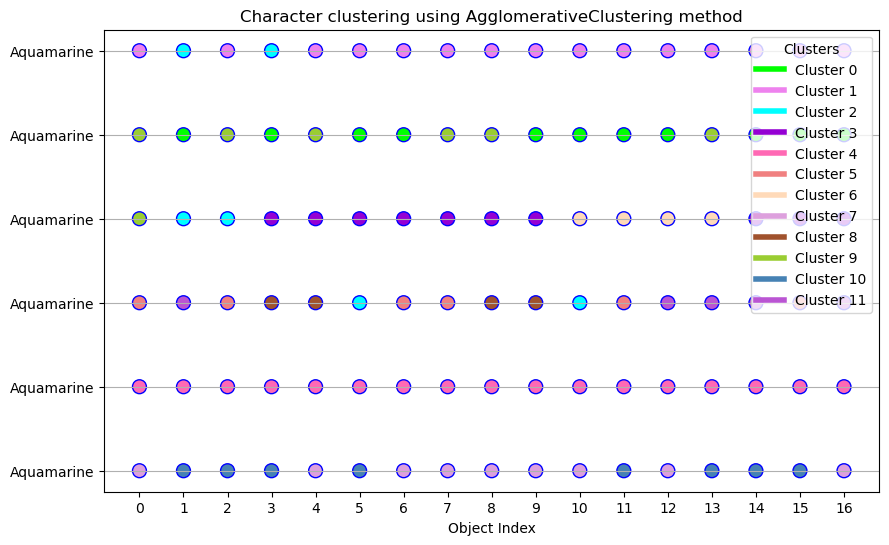

In [745]:
# Ваш код для определения данных остается тем же
x_positions = range(len(first_line_data_agl))


# Функция для форматирования значений оси Y
def format_y(value, tick_number):
    labels = ["Aquamarine", "Memte", "Cana", "Akane", "Ruby", "Ai"]  # Перестроенный порядок
    return labels[int(value * 0.2)]  # Умножаем на 5, чтобы получить индекс из диапазона от 0 до 5


formatter = FuncFormatter(format_y)

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Добавляем первую строку точек на графике
plt.scatter(
    x_positions,
    [1.0] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in first_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="First Line",
)

# Добавляем вторую строку точек на графике
plt.scatter(
    x_positions,
    [0.8] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in second_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Second Line",
)

# Добавляем третью строку точек на графике
plt.scatter(
    x_positions,
    [0.6] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in third_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Third Line",
)

# Добавляем четвертую строку точек на графике
plt.scatter(
    x_positions,
    [0.4] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in fourth_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fourth Line",
)

# Добавляем пятую строку точек на графике
plt.scatter(
    x_positions,
    [0.2] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in fifth_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fifth Line",
)

# Добавляем шестую строку точек на графике
plt.scatter(
    x_positions,
    [0] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "violet"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "hotpink"
            if label == 4
            else "lightcoral"
            if label == 5
            else "peachpuff"
            if label == 6
            else "plum"
            if label == 7
            else "sienna"
            if label == 8
            else "yellowgreen"
            if label == 9
            else "steelblue"
            if label == 10
            else "mediumorchid"
            if label == 11
            else "whitesmoke"
            if label == 12
            else "rosybrown"
            if label == 13
            else "tomato"
            if label == 14
            else "blanchedalmond"
        )
        for label in sixth_line_data_agl
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Sixth Line",
)


# Создаем список для легенды с указанием цветов
legend_elements = [
    plt.Line2D([0], [0], color="lime", lw=4, label="Cluster 0"),
    plt.Line2D([0], [0], color="violet", lw=4, label="Cluster 1"),
    plt.Line2D([0], [0], color="cyan", lw=4, label="Cluster 2"),
    plt.Line2D(
        [0], [0], color="darkviolet", lw=4, label="Cluster 3"
    ),
    plt.Line2D([0], [0], color="hotpink", lw=4, label="Cluster 4"),
    plt.Line2D([0], [0], color="lightcoral", lw=4, label="Cluster 5"),
    plt.Line2D([0], [0], color="peachpuff", lw=4, label="Cluster 6"),
    plt.Line2D(
        [0], [0], color="plum", lw=4, label="Cluster 7"
    ), 
    plt.Line2D([0], [0], color="sienna", lw=4, label="Cluster 8"),
    plt.Line2D([0], [0], color="yellowgreen", lw=4, label="Cluster 9"),
    plt.Line2D([0], [0], color="steelblue", lw=4, label="Cluster 10"),
    plt.Line2D(
        [0], [0], color="mediumorchid", lw=4, label="Cluster 11"
    ),
    # plt.Line2D([0], [0], color="whitesmoke", lw=4, label="Cluster 12"),
    # plt.Line2D([0], [0], color="rosybrown", lw=4, label="Cluster 13"),
    # plt.Line2D([0], [0], color="tomato", lw=4, label="Cluster 14"),

]

# Добавляем легенду для меток кластеров
plt.legend(handles=legend_elements, title="Clusters")


formatter = FuncFormatter(format_y)
ax.yaxis.set_major_formatter(formatter)
plt.title("Character clustering using AgglomerativeClustering method")
plt.xlabel("Object Index")
# plt.ylabel("Line Position")
plt.xticks(x_positions)  # Поворачиваем метки оси X на 45 градусов для лучшей читаемости
plt.grid(axis="y")
plt.show()

---

### Cosine

In [606]:
mmm = 'data/metrics/formetric.json'

# Чтение данных из файла
with open(mmm, 'r') as file:
    data_met = json.load(file)

# Предполагаем, что данные представляют собой список numpy массивов
numpy_arrays_for = [np.array(sublist) for sublist in data_met]

In [607]:
crop_embedddings_cos = None

In [608]:
# Проходим по каждому элементу в подмножестве
for i in range(len(numpy_arrays_for)):

    torch_tensor_met = torch.from_numpy(numpy_arrays_for[i])
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings_agl = torch_tensor_met.unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_cos is None:
        crop_embedddings_cos = current_embeddings_agl
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_cos = torch.cat((crop_embedddings_cos, current_embeddings_agl), dim=0)

In [21]:
type(crop_embedddings_cos)

torch.Tensor

In [609]:
small_list = [crop_embedddings_cos]

In [610]:
compare_list = []

In [611]:
# Перебираем все подмножества в sublists_for_embedddings
for one_pack_for_analysis in small_list:

    # Матрица с косинусными совпадениями все-на-все
    pcs = pairwise_cosine_similarity(one_pack_for_analysis, one_pack_for_analysis)
    # Меняем единицы в главной диагонали на нули
    pcs = pcs.fill_diagonal_(0.0)
    # Получаем индексы всех максимумов - лучшие совпадения
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    new_var = torch.argmax(pcs, dim=1)
    # Убедитесь, что все тензоры находятся на этом устройстве
    new_var = new_var.to(device)
    range_tens = torch.arange(len(new_var)).to(device)

    # Теперь выполняем операцию объединения
    char_to = torch.cat(
        (new_var.unsqueeze(1), range_tens.unsqueeze(1)), dim=1
    )
    # Делаем граф из совпадающих вершин
    graphs_chapter_one_max = nx.Graph(char_to.tolist())
    # Объединяем все совпавшие вершины друг с другом  
    indixes_per_chapter = [
        list(c_) for c_ in nx.connected_components(graphs_chapter_one_max)
    ]
    # Создаём список compare_list и добавляем внутри него тензоры
    for c_k in indixes_per_chapter:
        for character_index in range(len(c_k)):
            num = int(c_k[character_index])
            if character_index == 0:
                first_compare_batch = one_pack_for_analysis[num].unsqueeze(dim=0)
            else:
                first_compare_batch = torch.cat(
                    (first_compare_batch, one_pack_for_analysis[num].unsqueeze(dim=0)), dim=0
                )
        compare_list.append(first_compare_batch)


In [612]:
images_samples = []

In [613]:
directory_path_samples = "data/samples/zv"

In [620]:
# Заглушка для чтения файлов из папки с примерами раскраски
for filename in os.listdir(directory_path_samples):
    full_path = os.path.join(directory_path_samples, filename)
    try:
        img = np.asarray(Image.open(full_path).convert("RGB"))
        images_samples.append(SampleImage(sample_image=img, full_file_name=full_path))
    except Exception as e:
        print(f"Ошибка при открытии {full_path}: {e}")


In [621]:
id_number = 0

In [622]:
images_color_for_analysis = []

In [623]:
list_of_compare_embeddings = []

In [629]:
for batch in images_samples:
    with torch.no_grad():
        page_image = [batch.sample_image]
        page_name = batch.full_file_name

        (
            batch_crop_bboxes,
            batch_crop_embeddings_for_batch,
            batch_image_bboxes,
            batch_character_scores,
        ) = model.get_crops_and_embeddings(page_image)

    num_rows = len(batch_crop_embeddings_for_batch[0])

    for i in range(num_rows):
        images_color_for_analysis.append(
            AnalisysSampleImage(
                id_sample_image=i+id_number,
                sample_image=batch_image_bboxes[0][i],
                embeddings_for_batch=batch_crop_embeddings_for_batch[0][i],
                full_file_name=page_name,
            )
        )
        list_of_compare_embeddings.append(batch_crop_embeddings_for_batch[0][i])
    
    id_number = id_number + num_rows


In [630]:
len(images_color_for_analysis)

9

In [631]:
images_color_for_analysis[4].id_sample_image

4

In [632]:
for i in range(len(images_color_for_analysis)):
    
    print(images_color_for_analysis[i].full_file_name)

data/samples/zv/0.png
data/samples/zv/0.png
data/samples/zv/4.png
data/samples/zv/1.png
data/samples/zv/3.png
data/samples/zv/3.png
data/samples/zv/3.png
data/samples/zv/2.png
data/samples/zv/2.png


In [46]:
crop_embedddings_sample = None

In [47]:
# Проходим по каждому элементу в подмножестве
for i in range(len(list_of_compare_embeddings)):
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings = list_of_compare_embeddings[i].unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_sample is None:
        crop_embedddings_sample = current_embeddings
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_sample = torch.cat((crop_embedddings_sample, current_embeddings), dim=0)
    

In [48]:
result_dict = {}

In [49]:
sample_dict = {}

In [50]:
for one_tensor in compare_list:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Убедитесь, что оба тензора находятся на этом устройстве и имеют одинаковый тип данных
    one_tensor = one_tensor.to(device).to(torch.float32)
    crop_embedddings_sample = crop_embedddings_sample.to(device).to(torch.float32)
    # Составляем матрицу и сравниваем с самплами
    pcs_samples = pairwise_cosine_similarity(one_tensor, crop_embedddings_sample)
    # Ищем сумму по всем значениям
    comp = torch.sum(pcs_samples, dim=0)
    # Ищем индекс максимального совпадения
    max_coincidence = int(torch.argmax(comp))
    if result_dict.get(max_coincidence) is not None:
        inter_res = torch.cat(
                (result_dict[max_coincidence], one_tensor), dim=0)
        result_dict[max_coincidence] = inter_res
    else:
        result_dict[max_coincidence] = one_tensor
        # Запись под аналогичным номером эмбеддинга с примером раскраски
        sample_dict[max_coincidence] = crop_embedddings_sample[max_coincidence]
    

In [51]:
small_list[0].shape

torch.Size([102, 768])

In [52]:
my_tensor = small_list[0]

In [53]:
len(small_list[0][0])

768

In [347]:
pp(result_dict[0])

tensor([[ 0.1162, -0.0549, -0.1506,  ...,  0.0559,  0.0313,  0.1015],
│   │   [ 0.0654, -0.1277, -0.0974,  ..., -0.0289, -0.1323, -0.0149],
│   │   [-0.0407, -0.0537, -0.1733,  ...,  0.1025, -0.0065,  0.1319],
│   │   ...,
│   │   [ 0.1313, -0.0748, -0.0913,  ..., -0.1011, -0.0181,  0.0370],
│   │   [ 0.2894, -0.0334, -0.2146,  ..., -0.0701, -0.1293,  0.0821],
│   │   [ 0.2471, -0.0585, -0.0976,  ...,  0.0579, -0.0443,  0.1025]],
│      device='cuda:0')

In [54]:
for key in result_dict.keys():
    print(key)

2
0
3
6
1
5


In [55]:
my_tensor = my_tensor.to(device)

In [114]:
first_tensor = result_dict[6]

# Проверка на абсолютное совпадение с каждой строкой в my_tensor
matches = []

In [57]:
len(first_tensor)

25

In [58]:
len(my_tensor)

102

In [115]:
# Перемещаем тензоры на одно и то же устройство (например, на GPU, если доступен)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_t = first_tensor.to(device)
second_t = my_tensor.to(device)

# Инициализируем список для хранения индексов совпадающих строк
matching_indices6 = []

# Сравниваем каждую строку в first_t со всеми строками во втором тензоре
for i in range(first_t.shape[0]):
    for j in range(second_t.shape[0]):
        if torch.all(torch.eq(first_t[i], second_t[j])):
            matching_indices6.append(j)

# Выводим индексы совпадающих строк
print(matching_indices6)

[34, 42, 50, 19, 21, 24, 25, 30, 68, 72, 74, 75, 82, 69, 70, 78, 79, 80, 84, 83, 77, 71, 73, 81, 76]


In [363]:
matching_indices1

[37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 52, 54, 55, 59, 60, 57, 53]

In [360]:
matching_indices6

[34,
 42,
 50,
 19,
 21,
 24,
 25,
 30,
 68,
 72,
 74,
 75,
 82,
 69,
 70,
 78,
 79,
 80,
 84,
 83,
 77,
 71,
 73,
 81,
 76]

In [95]:
matching_indices3

[34,
 42,
 50,
 19,
 21,
 24,
 25,
 30,
 68,
 72,
 74,
 75,
 82,
 69,
 70,
 78,
 79,
 80,
 84,
 83,
 77,
 71,
 73,
 81,
 76]

In [96]:
matching_indices2

[34,
 42,
 50,
 19,
 21,
 24,
 25,
 30,
 68,
 72,
 74,
 75,
 82,
 69,
 70,
 78,
 79,
 80,
 84,
 83,
 77,
 71,
 73,
 81,
 76]

---

In [99]:
cos_for_metrics = [0] * 102

In [116]:
indices_to_replace = matching_indices6

In [117]:
for index in indices_to_replace:
    cos_for_metrics[index] = 5

In [92]:
cos_for_metrics

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 6,
 0,
 0,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

---

In [ ]:
pp(cos_for_metrics)

### Сам график

In [654]:
cos_for_metrics = [2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,5,3,3,3,5,3,3,3,3,5,3,3,3,5,1,2,1,1,1,1,1,5,1,1,1,1,1,1,1,1,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]

In [655]:
first_line_data_cos = cos_for_metrics[:17]
second_line_data_cos = cos_for_metrics[17:34]
third_line_data_cos = cos_for_metrics[34:51]
fourth_line_data_cos = cos_for_metrics[51:68]
fifth_line_data_cos = cos_for_metrics[68:85]
sixth_line_data_cos = cos_for_metrics[85:102]

In [656]:
pp(fourth_line_data_cos)

[0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

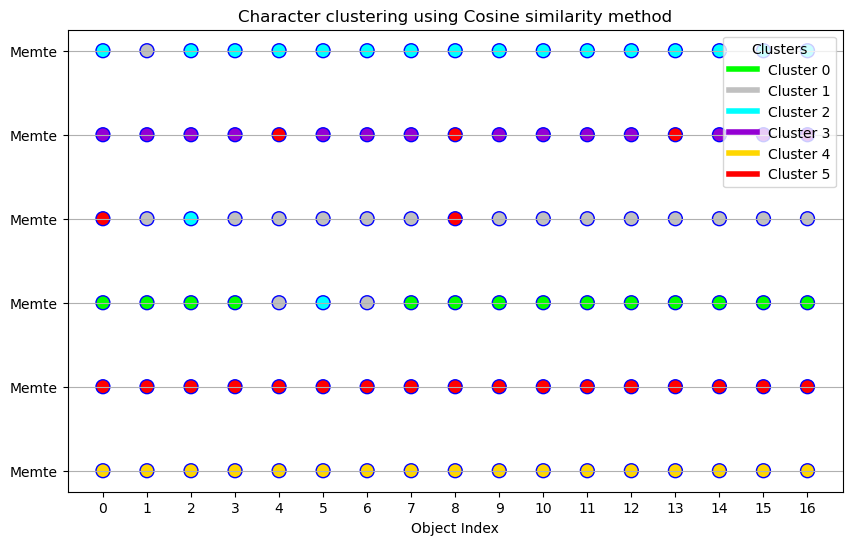

In [657]:
# Ваш код для определения данных остается тем же
x_positions = range(len(fifth_line_data_cos))


# Функция для форматирования значений оси Y
def format_y(value, tick_number):
    #labels = ["Aquamarine", "Memte", "Cana", "Akane", "Ruby", "Ai"]  # Перестроенный порядок
    labels = ["Memte", "Memte", "Memte", "Memte", "Memte", "Memte"]  #
    return labels[int(value * 0.2)]  # Умножаем на 5, чтобы получить индекс из диапазона от 0 до 5


formatter = FuncFormatter(format_y)

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Добавляем первую строку точек на графике
plt.scatter(
    x_positions,
    [1.0] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in first_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="First Line",
)

# Добавляем вторую строку точек на графике
plt.scatter(
    x_positions,
    [0.8] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in second_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Second Line",
)

# Добавляем третью строку точек на графике
plt.scatter(
    x_positions,
    [0.6] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in third_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Third Line",
)

# Добавляем четвертую строку точек на графике
plt.scatter(
    x_positions,
    [0.4] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in fourth_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fourth Line",
)

# Добавляем пятую строку точек на графике
plt.scatter(
    x_positions,
    [0.2] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in fifth_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Fifth Line",
)

# Добавляем шестую строку точек на графике
plt.scatter(
    x_positions,
    [0] * len(x_positions),
    c=[
        "lime"
        if label == 0
        else (
            "silver"
            if label == 1
            else "cyan"
            if label == 2
            else "darkviolet"
            if label == 3
            else "gold"
            if label == 4
            else "red"
        )
        for label in sixth_line_data_cos
    ],
    marker="o",
    s=100,  # Установлен размер кружочка равным 100
    edgecolors="b",
    label="Sixth Line",
)


# Создаем список для легенды с указанием цветов
legend_elements = [
    plt.Line2D([0], [0], color="lime", lw=4, label="Cluster 0"),
    plt.Line2D([0], [0], color="silver", lw=4, label="Cluster 1"),
    plt.Line2D([0], [0], color="cyan", lw=4, label="Cluster 2"),
    plt.Line2D(
        [0], [0], color="darkviolet", lw=4, label="Cluster 3"
    ),
    plt.Line2D([0], [0], color="gold", lw=4, label="Cluster 4"),
    plt.Line2D([0], [0], color="red", lw=4, label="Cluster 5"),


]

# Добавляем легенду для меток кластеров
plt.legend(handles=legend_elements, title="Clusters")


formatter = FuncFormatter(format_y)
ax.yaxis.set_major_formatter(formatter)
plt.title("Character clustering using Cosine similarity method")
plt.xlabel("Object Index")
# plt.ylabel("Line Position")
plt.xticks(x_positions)  # Поворачиваем метки оси X на 45 градусов для лучшей читаемости
plt.grid(axis="y")
plt.show()

In [646]:
ml1 = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]

In [638]:
ml2 = []

In [649]:
len(ml)

102

---

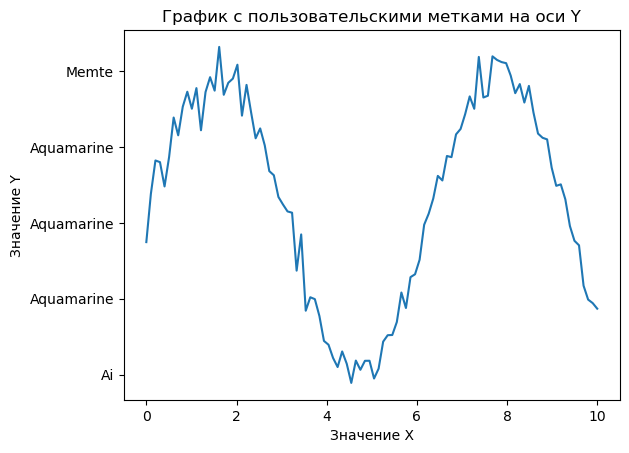

In [403]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Ваш список имен
labels = ["Aquamarine", "Memte", "Cana", "Akane", "Ruby", "Ai"]

# Функция для получения имени по значению Y
def get_label_by_value(value):
    # Индекс для выбора имени из списка labels
    index = min(int(value), len(labels) - 1)
    return labels[index]

# Форматтер для оси Y
def format_y(value, tick_number):
    return get_label_by_value(value)

# Генерируем данные для примера
import numpy as np
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=len(x))

# Создаем график
fig, ax = plt.subplots()

# Добавляем данные на график
ax.plot(x, y)

# Применяем formatter к оси Y
ax.yaxis.set_major_formatter(FuncFormatter(format_y))

# Настройка остальных параметров графика
plt.title("График с пользовательскими метками на оси Y")
plt.xlabel("Значение X")
plt.ylabel("Значение Y")

# Отображаем график
plt.show()


---

### 11

In [ ]:
### 111

In [101]:
for character_index in range(len(c_k)):
        num = int(c_k[character_index])
        if character_index == 0:
            first_compare_batch = crop_embedddings_cos.unsqueeze(dim=0)
        else:
            first_compare_batch = torch.cat(
                (first_compare_batch, crop_embedddings_cos.unsqueeze(dim=0)), dim=0
            )

In [98]:
compare_list = []

In [99]:
# Создаём список compare_list и добавляем внутри него тензоры
for c_k in indixes_per_chapter:
    for character_index in range(len(c_k)):
        num = int(c_k[character_index])
        if character_index == 0:
            first_compare_batch = crop_embedddings_cos.unsqueeze(dim=0)
        else:
            first_compare_batch = torch.cat(
                (first_compare_batch, crop_embedddings_cos.unsqueeze(dim=0)), dim=0
            )
    compare_list.append(first_compare_batch)

### На всякий случай оставлю

In [591]:
from sklearn.cluster import HDBSCAN, AgglomerativeClustering

hdb = HDBSCAN()
agg_cl = AgglomerativeClustering(n_clusters=None, distance_threshold=7.)

In [595]:
crop_embedddings_all = None

In [596]:
# Проходим по каждому элементу в подмножестве
for i in range(len(My_new_list)):
    # Извлекаем эмбеддинги из текущего элемента
    current_embeddings_hgd = My_new_list[i].unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    if crop_embedddings_all is None:
        crop_embedddings_all = current_embeddings_hgd
    else:
        # Иначе объединяем текущие эмбеддинги с предыдущими
        crop_embedddings_all = torch.cat((crop_embedddings_all, current_embeddings_hgd), dim=0)

In [597]:
hdb.fit(crop_embedddings_all.cpu().numpy())
agg_cl.fit(crop_embedddings_all.cpu().numpy())


AgglomerativeClustering(distance_threshold=7.0, n_clusters=None)

In [598]:
np.array(list(zip(range(len(My_new_list)), hdb.labels_, hdb.probabilities_, strict=False)))

array([[  0.        ,   0.        ,   1.        ],
       [  1.        ,  -1.        ,   0.        ],
       [  2.        ,   0.        ,   1.        ],
       [  3.        ,   0.        ,   0.824704  ],
       [  4.        ,   0.        ,   0.89752334],
       [  5.        ,   0.        ,   0.9913286 ],
       [  6.        ,   0.        ,   1.        ],
       [  7.        ,   0.        ,   0.9820989 ],
       [  8.        ,  -1.        ,   0.        ],
       [  9.        ,   0.        ,   1.        ],
       [ 10.        ,   0.        ,   1.        ],
       [ 11.        ,  -1.        ,   0.        ],
       [ 12.        ,   0.        ,   0.81104428],
       [ 13.        ,   0.        ,   0.93211387],
       [ 14.        ,   0.        ,   0.98649449],
       [ 15.        ,   0.        ,   0.88528265],
       [ 16.        ,   0.        ,   0.87284055],
       [ 17.        ,   2.        ,   0.99024446],
       [ 18.        ,  -1.        ,   0.        ],
       [ 19.        ,   2.     

In [ ]:
# Округляем метки кластеров до ближайшего целого числа
rounded_labels = np.round(results[:, 1]).astype(int)

# Используем округленные метки для определения количества цветов в колесе цветов
colors = plt.cm.get_cmap('tab20', max(rounded_labels) + 1)

In [614]:
hdb.labels_

array([ 0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,
        2, -1,  2,  2,  2, -1,  2,  2, -1, -1, -1, -1, -1,  2, -1,  2, -1,
       -1, -1, -1, -1,  2,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1,  2,  2,
        0, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1,  0,  0, -1,
        3, -1,  3,  3,  3,  3,  3,  3,  3,  3, -1,  3,  3,  3,  3,  3,  3,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1])

In [688]:
from matplotlib.ticker import FuncFormatter

In [646]:
symbols = list(hdb.labels_)

# Разделение списка на части по 17 символов
sublists_sym = [symbols[i:i+17] for i in range(0, len(symbols), 17)]

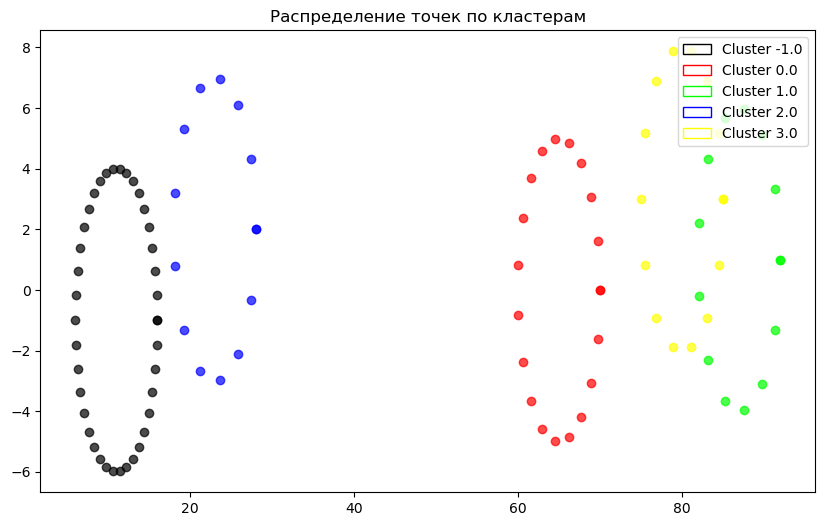

In [645]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что results - это ваш массив с номерами изображений, метками кластеров и вероятностями
results = np.array(list(zip(range(len(My_new_list)), hdb.labels_, hdb.probabilities_)))

# Группировка точек по кластерам
clusters = {}
for i, (_, label, _) in enumerate(results):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(i)

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))

# Определение ярких и контрастных цветов для 4 кластеров
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#000000']  # Красный, Зеленый, Синий, Желтый

for label, points in clusters.items():
    # Выбираем случайную точку в качестве центра круга
    center_index = np.random.choice(points)
    center_point = results[center_index][:2]  # Берем только номер изображения и метку кластера
    
    # Расчет радиуса для круга
    radius = 5  # Увеличиваем радиус для лучшего видимости
    
    # Распределяем точки вокруг центра в форме круга
    angles = np.linspace(0, 2 * np.pi, len(points))  # Генерируем равномерно распределенные углы
    for angle in angles:
        x = center_point[0] + radius * np.cos(angle)
        y = center_point[1] + radius * np.sin(angle)
        ax.scatter(x, y, color=colors[int(label)], alpha=0.7)

# Добавляем легенду
handles, labels = [], []
for label in sorted(clusters.keys()):
    handles.append(plt.Circle((0, 0), 0.5, fill=False, color=colors[int(label)]))  # Примерный размер для легенды
    labels.append(f'Cluster {label}')
plt.legend(handles, labels, loc='upper right')

ax.set_title('Распределение точек по кластерам')
plt.show()


---

In [571]:
from sklearn.preprocessing import MinMaxScaler

In [572]:
# Предположим, что data - это список тензоров PyTorch
scaler = MinMaxScaler()

In [573]:
# Инициализация пустого списка для хранения нормализованных тензоров
normalized_tensors = []

In [574]:
for tensor in My_new_list:
    # Перемещаем каждый тензор на CPU и преобразуем в массив NumPy
    tensor_np = tensor.cpu().numpy()
    
    # Нормализуем тензор и добавляем его в список
    normalized_tensor = scaler.partial_fit(tensor_np.reshape(-1, 1)).transform(tensor_np.reshape(-1, 1))
    normalized_tensors.append(normalized_tensor.ravel())




In [575]:
len(normalized_tensors)

102

In [576]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(normalized_tensors) 

In [582]:
data_normalized.shape

(102, 768)

In [583]:
# Применение HDBSCAN
clustering = HDBSCAN(min_cluster_size=10, min_samples=None).fit(data_normalized)


In [584]:
# Получение меток кластеров
labels = clustering.labels_

In [588]:
import matplotlib.pyplot as plt

In [590]:
plt.figure(figsize=(10, 6))
for label in set(labels):
    plt.scatter(*slovar.values(), c=[label if cluster_label == label else 'gray' for cluster_label in labels])
plt.show()

TypeError: scatter() got multiple values for argument 'c'

<Figure size 1000x600 with 0 Axes>

In [586]:
hdb = HDBSCAN()

---

In [587]:
np.array(list(zip(range(102), labels, hdb.probabilities_, strict=False)))


AttributeError: 'HDBSCAN' object has no attribute 'probabilities_'

---

In [ ]:
# Если вам нужен единый массив NumPy вместо списка массивов, вы можете объединить их
normalized_data = np.concatenate(normalized_tensors)

In [296]:
len(Others)

14

In [241]:
torch.tensor(torch.cat(list_of_embedddings, dim=-1))

/tmp/ipykernel_49222/186661472.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(torch.cat(list_of_embedddings, dim=-1))


tensor([ 0.0749, -0.0090, -0.0696,  ..., -0.0144,  0.0405,  0.1035],
       device='cuda:0')

In [243]:
for i in range(len(list_of_embedddings)):
    # Извлекаем эмбеддинги из текущего элемента
    cur_embeddings = list_of_embedddings[i].unsqueeze(dim=0)
    
    # Если crop_embeds_bw еще не инициализирована, инициализируем ее текущими эмбеддингами
    crop_b = cur_embeddings

In [568]:
from sklearn.cluster import HDBSCAN, AgglomerativeClustering

In [281]:
from sklearn.cluster import HDBSCAN, AgglomerativeClustering

hdb = HDBSCAN()
agg_cl = AgglomerativeClustering(n_clusters=None, distance_threshold=7.)

In [282]:
hdb.fit(crop_b.cpu().numpy())
agg_cl.fit(crop_b.cpu().numpy())


AgglomerativeClustering(distance_threshold=7.0, n_clusters=None)

In [283]:
agg_cl.n_clusters_, agg_cl.n_connected_components_

(8, 1)

In [284]:
np.array(list(zip(range(len(list_of_embedddings)), hdb.labels_, hdb.probabilities_, strict=False)))


array([[ 0.        ,  0.        ,  1.        ],
       [ 1.        , -1.        ,  0.        ],
       [ 2.        , -1.        ,  0.        ],
       [ 3.        ,  0.        ,  0.91646257],
       [ 4.        , -1.        ,  0.        ],
       [ 5.        , -1.        ,  0.        ],
       [ 6.        , -1.        ,  0.        ],
       [ 7.        ,  2.        ,  0.91397456],
       [ 8.        , -1.        ,  0.        ],
       [ 9.        ,  2.        ,  0.96389248],
       [10.        ,  0.        ,  0.85850842],
       [11.        ,  0.        ,  1.        ],
       [12.        ,  2.        ,  0.94422217],
       [13.        ,  0.        ,  1.        ],
       [14.        ,  0.        ,  1.        ],
       [15.        ,  0.        ,  1.        ],
       [16.        , -1.        ,  0.        ],
       [17.        ,  1.        ,  0.82883458],
       [18.        ,  1.        ,  1.        ],
       [19.        ,  1.        ,  0.75993327],
       [20.        , -1.        ,  0.   

In [285]:
np.array(list(zip(range(len(list_of_embedddings)), agg_cl.labels_, strict=False)))


array([[ 0,  1],
       [ 1,  0],
       [ 2,  0],
       [ 3,  1],
       [ 4,  0],
       [ 5,  0],
       [ 6,  1],
       [ 7,  3],
       [ 8,  0],
       [ 9,  3],
       [10,  1],
       [11,  1],
       [12,  3],
       [13,  1],
       [14,  5],
       [15,  1],
       [16,  0],
       [17,  6],
       [18,  2],
       [19,  4],
       [20,  4],
       [21,  4],
       [22,  4],
       [23,  0],
       [24,  7],
       [25,  6],
       [26,  4],
       [27,  5],
       [28,  0],
       [29,  4],
       [30,  3],
       [31,  5],
       [32,  5],
       [33,  6],
       [34,  0],
       [35,  0],
       [36,  4],
       [37,  2],
       [38,  2],
       [39,  2],
       [40,  4],
       [41,  4],
       [42,  2],
       [43,  5],
       [44,  4],
       [45,  5],
       [46,  4],
       [47,  1],
       [48,  6],
       [49,  3],
       [50,  1],
       [51,  4],
       [52,  2],
       [53,  3],
       [54,  3],
       [55,  4],
       [56,  1],
       [57,  6],
       [58,  4

### Гомогенность

In [662]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score


In [663]:
ideal_list = []

In [664]:
for i in range(6):
    for j in range(17):
        ideal_list.append(i)

In [665]:
homogeneity_score_cos = homogeneity_score(ideal_list, cos_for_metrics)

In [666]:
completeness_score_cos = completeness_score(ideal_list, cos_for_metrics)

In [667]:
beta = 1

In [668]:
v_cos = (
    (1 + beta)
    * homogeneity_score_cos
    * completeness_score_cos
    / (beta * homogeneity_score_cos + completeness_score_cos)
)

In [669]:
homogeneity_score_cos

np.float64(0.8213335889145813)

In [670]:
completeness_score_cos

np.float64(0.8270569494697767)

In [671]:
v_cos

np.float64(0.8241853331802687)

### AGJ

In [734]:
type(data_agl)

numpy.ndarray

In [735]:
data_agl_ = data_agl.tolist()

In [736]:
homogeneity_score_agl = homogeneity_score(ideal_list, data_agl_)

In [737]:
completeness_score_agl = completeness_score(ideal_list, data_agl_)

In [738]:
v_agl = (
    (1 + beta)
    * homogeneity_score_agl
    * completeness_score_agl
    / (beta * homogeneity_score_agl + completeness_score_agl)
)

In [739]:
v_agl

np.float64(0.8142736022781966)

In [740]:
completeness_score_agl

np.float64(0.7134834756078007)

In [741]:
homogeneity_score_agl

np.float64(0.9482243619205434)

### HBDSCAN

In [598]:
type(data_hbd)

list

In [599]:
homogeneity_score_hbd = homogeneity_score(ideal_list, data_hbd)

In [600]:
completeness_score_hbd = completeness_score(ideal_list, data_hbd)

In [601]:
v_hbd = (
    (1 + beta)
    * homogeneity_score_hbd
    * completeness_score_hbd
    / (beta * homogeneity_score_hbd + completeness_score_hbd)
)

In [602]:
v_hbd

np.float64(0.6286454553263773)

In [603]:
completeness_score_hbd

np.float64(0.6735907474416724)

In [604]:
homogeneity_score_hbd

np.float64(0.5893229271981878)